In [1]:
# imports

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

### Loading frames

In [2]:
img = Image.open('first_frame.png')
first_frame = np.array(img.convert('L'), dtype = float)

img = Image.open('second_frame.png')
second_frame = np.array(img.convert('L'), dtype = float)

Divide each frame into non-overlapping macroblocks of size $16 × 16$ pixels. Note that the images are of size
$176 × 144$.

In [3]:
def divide_into_blocks(frame):
    
    M,N = frame.shape

    row_blocks = N // 16
    col_blocks = M // 16

    X = np.zeros((col_blocks, row_blocks, 16, 16))

    for i in range(col_blocks):

        for j in range(row_blocks):

            start_i = 16 * i
            start_j = 16 * j
            block = frame[start_i : start_i + 16, start_j : start_j + 16]

            X[i, j] = block
            
    return X
            
F1 = divide_into_blocks(first_frame)
F2 = divide_into_blocks(second_frame)

Use MAD (Mean absolute distance) as the distance metric.

In [4]:
def find_MAD(block1, block2):
    
    num_pixels = block1.shape[0] * block1.shape[1]
    
    return np.sum(np.abs(block1 - block2)) / num_pixels

### Motion Estimation

1.  Use the 3-step search to find motion vectors. 

In [5]:
def find_search_inds(k, row, col):
    
    """
    k     :  Pixel-wise distance between two blocks to be searched.
    row   :  The pixel row number of top left corner of block.
    col   :  The pixel col number of top left corner of block.
    
    """
    
    search_inds = [(row,col)]
    
    candidates = [(-k, 0), (-k, k), (0, -k), (k, -k), (k, 0), (k, k), (0, k), (-k, -k)]
    
    for r,c in candidates:
        
        start_row = row + r
        start_col = col + c
        end_row = start_row + 15
        end_col = start_col + 15
        
        if (start_row >= 0 and start_col >=0 and end_row < 144 and end_col < 176):
            
            search_inds.append((start_row, start_col))
            
    return search_inds

In [6]:
def three_step_search(search_block, sb_row, sb_col, search_frame):
    
    """
    search_block  : The macro block of second_frame, whose motion vector is to be found.
    sb_row        : The macro block row number of the search_block within second_frame.
    sb_col        : The macro block col number of the search_block within second_frame.
    search_frame  : The video frame in which macro blocks are being searched for. (Here, first_frame)
    
    """
    min_row = 0
    min_col = 0
    
    # step 1
    min_MAD = 10000
    search_inds = find_search_inds(4, 16 * sb_row, 16 * sb_col)
    
    for r,c in search_inds:
        block = search_frame[r : r+16, c : c+16]
        MAD = find_MAD(search_block, block)
        if (MAD < min_MAD):
            min_row, min_col = r, c
            min_MAD = MAD            
    
    # step 2
    min_MAD = 10000
    search_inds = find_search_inds(2, min_row, min_col)
    
    for r,c in search_inds:
        block = search_frame[r : r+16, c : c+16]
        MAD = find_MAD(search_block, block)
        if (MAD < min_MAD):
            min_row, min_col = r, c
            min_MAD = MAD
    
    # step 3
    min_MAD = 10000
    search_inds = find_search_inds(1, min_row, min_col)
    
    for r,c in search_inds:
        block = search_frame[r : r+16, c : c+16]
        MAD = find_MAD(search_block, block)
        if (MAD < min_MAD):
            min_row, min_col = r, c
            min_MAD = MAD
    
    return (min_row, min_col)

In [7]:
# Finding motion vectors at each macroblock in the second frame from the first.

rows, cols = F2.shape[0], F2.shape[1]
blocks_in_first_frame = []
blocks_in_second_frame = []

for row in range(rows):
    for col in range(cols):
        
        blocks_in_first_frame.append(three_step_search(F2[row][col], row, col, first_frame))
        blocks_in_second_frame.append((row * 16, col * 16))


2. Plot the motion vector at each macroblock.

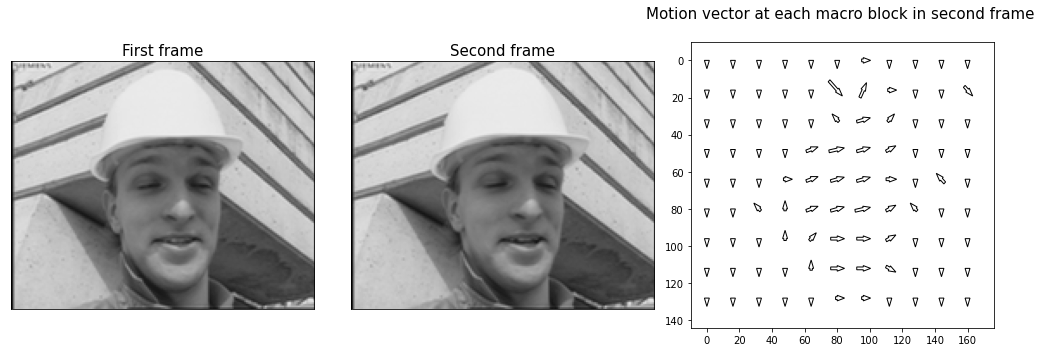

In [38]:
images = [first_frame, second_frame]
names = ['First frame', 'Second frame']

fig, ax = plt.subplots(1, 3, figsize = (14,5))

for i in range(len(images)):
    
    plt.subplot(1, 3, i + 1)
    ax[i].imshow(images[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(names[i], size = 15)

plt.subplot(1, 3, 3)
ax[2].invert_yaxis()

plt.xlim(-10,176)
plt.ylim(144,-10)
plt.xticks(np.arange(0,176,20))
plt.yticks(np.arange(140,-1,-20))
plt.title('Motion vector at each macro block in second frame \n', size = 15)

for (r1, c1), (r2, c2) in zip(blocks_in_first_frame, blocks_in_second_frame):
    plt.arrow(c1, r1, c2 - c1, r2 - r1, width = 1.5, length_includes_head = False, head_width = 3, 
              color = 'white', ec = 'black')
    

fig.tight_layout()
plt.show()

3. Generate the motion compensated predicted frame using the motion vectors and the first frame.

In [43]:
Motion_compensated_second_frame = np.zeros((144,176))

M,N = second_frame.shape

row_blocks = N // 16
col_blocks = M // 16
num_blocks = row_blocks * col_blocks

for i in range(num_blocks):
    
    r,c = blocks_in_first_frame[i]
    block = first_frame[r : r+16, c : c+16]
    
    row = 16 * (i // row_blocks)
    col = 16 * (i % row_blocks)
    
    Motion_compensated_second_frame[row : row+16, col : col+16] = block

4. Compute the error between the second frame and its motion compensated predicted version and display it

In [47]:
# SSIM

def pad_for_SSIM(image):
    
    N,M = image.shape
    start = 5
    
    new_image = np.zeros((N+10, M+10))
    
    # central part
    new_image[start:N+start, start:M+start] = image
    
    # edges
    for i in range(5):
        new_image[i, start:M+start] = image[start-i-1, :]
        new_image[start:N+start, i] = image[:, start-i-1]
        new_image[N+start+i, start:M+start] = image[N-start+i, :]
        new_image[start:N+start, M+start+i] = image[:, M-start+i]
    
    # corners
    new_image[:start, :start] = image[0, 0]
    new_image[:start, M+start:] = image[0, M-1]
    new_image[N+start:, :start] = image[N-1, 0]
    new_image[N+start:, M+start:] = image[N-1, M-1]
    
    return new_image

def gaussian_filter(window_size, sigma):
    
    W = np.zeros((window_size, window_size))
    start = window_size//2
    stop = start+1
    for i in range(-start, stop):
        for j in range(-start, stop):
            W[i+start][j+start] = np.exp(-(i**2 + j**2) / (2 * sigma**2))
    W = W / np.sum(W)
    
    return W

def get_SSIM(image1, image2, window_size, sigma):

    N, M = image1.shape
    N1, M1 = window_size, window_size
    
    padded_image1 = pad_for_SSIM(image1)
    padded_image2 = pad_for_SSIM(image2)
    
    W = gaussian_filter(window_size, sigma)
    
    Mu1, Mu2 = np.zeros((N,M)), np.zeros((N,M))
    Sig1, Sig2 = np.zeros((N,M)), np.zeros((N,M))
    sigma12 = np.zeros((N,M))
    
    L, C, S, SSIM = np.zeros((N,M)), np.zeros((N,M)), np.zeros((N,M)), np.zeros((N,M))
    
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2
    C3 = C2/2
    
    for i in range(N):
        for j in range(M):
            
            Mu1[i][j] = np.sum(np.multiply(W, padded_image1[i : i+N1, j : j+M1]))
            Mu2[i][j] = np.sum(np.multiply(W, padded_image2[i : i+N1, j : j+M1])) 
            Sig1[i][j] = np.sqrt(np.sum(np.multiply(W, np.power(padded_image1[i : i+N1, j : j+M1] - Mu1[i][j], 2))))
            Sig2[i][j] = np.sqrt(np.sum(np.multiply(W, np.power(padded_image2[i : i+N1, j : j+M1] - Mu2[i][j], 2))))
            sigma12[i][j] = np.sum(W*(padded_image1[i: i+N1,j: j+M1] - Mu1[i][j])*(padded_image2[i: i+N1,j: j+M1] - Mu2[i][j]))
            
            L[i][j] = (2*Mu1[i][j]*Mu2[i][j] + C1)/(Mu1[i][j]**2 + Mu2[i][j]**2 + C1)
            C[i][j] = (2*Sig1[i][j]*Sig2[i][j] + C2)/(Sig1[i][j]**2 + Sig2[i][j]**2 + C2)
            S[i][j] = (sigma12[i][j] + C3)/(Sig1[i][j]*Sig2[i][j] + C3)
            
            SSIM[i][j] = L[i][j] * C[i][j] * S[i][j]
    
    return SSIM, np.average(SSIM)

In [48]:
def find_MSE(image1, image2):
    
    image1 = image1.astype(np.float64)
    image2 = image2.astype(np.float64)

    MSE = np.zeros(image1.shape)
    N,M = image1.shape
    
    MSE = np.sum( (image1 - image2)**2 ) / (M*N)
    
    return MSE

In [49]:
MSE = find_MSE(second_frame, Motion_compensated_second_frame)

SSIM, MSSIM = get_SSIM(second_frame, Motion_compensated_second_frame, 11, 1)

In [51]:
print('The MSE for the motion compensated predicted frame is ', MSE)
print('The MSSIM score for the motion compensated predicted frame is ', MSSIM)

The MSE for the motion compensated predicted frame is  31.156407828282827
The MSSIM score for the motion compensated predicted frame is  0.9501677593839516


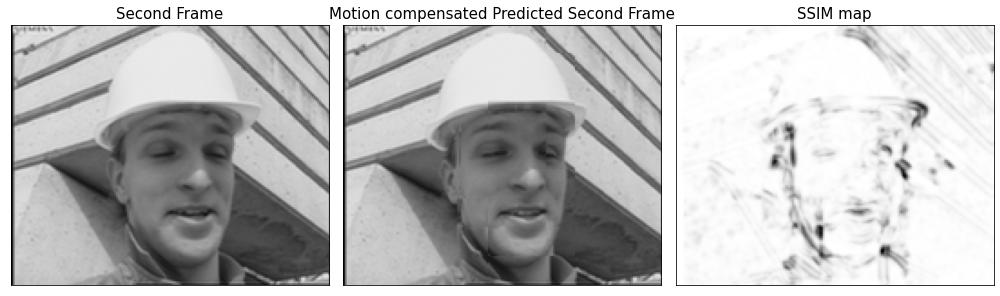

In [53]:
images = [second_frame, Motion_compensated_second_frame, SSIM]
names = ['Second Frame', 'Motion compensated Predicted Second Frame', 'SSIM map']

fig, ax = plt.subplots(1, 3, figsize = (14,5))

for i in range(len(images)):
    
    plt.subplot(1, 3, i + 1)
    ax[i].imshow(images[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(names[i], size = 15)

fig.tight_layout()